In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel
from klearn_tcyclone.kooplearn.models.nystroem import NystroemKernelCustom

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

from klearn_tcyclone.utils import check_time_steps_TCTracks
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling, slide_by_scaling, get_top_k_ev_below_zero, train_model
from klearn_tcyclone.climada.utils import get_TCTrack_dict

from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling

In [2]:
from kooplearn.data import TensorContextDataset, TrajectoryContextDataset
from numpy.typing import NDArray
from klearn_tcyclone.data_utils import periodic_identification, periodic_shift, periodic_shift_TensorContextDataset

cmap1 = plt.cm.coolwarm
cmap2 = plt.cm.Greens

In [22]:
print(BASINS)
basin = BASINS[6]
basin

['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA']


'SA'

In [25]:
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="official", year_range=(1980, 2011), basin=basin
)

2024-11-30 10:52:29,757 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


<GeoAxes: >

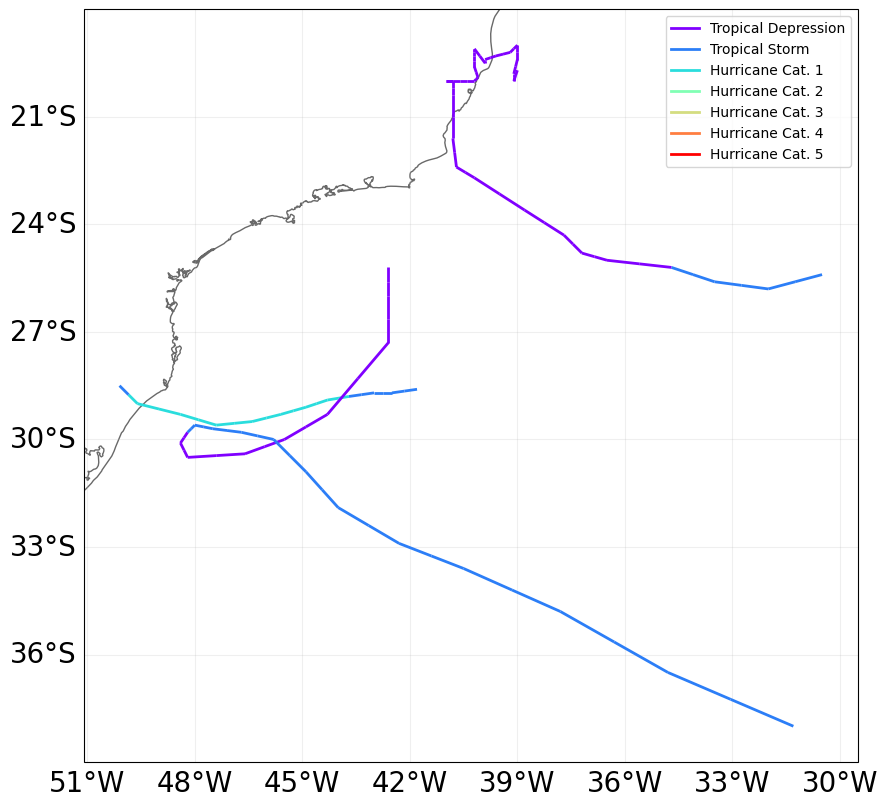

In [26]:
tc_tracks.plot()

In [27]:
context_length = 2
time_lag = 1
feature_list = ['lon', 'lat', 'max_sustained_wind', 'radius_max_wind', 'radius_oci', 'central_pressure', 'environmental_pressure']

In [28]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    context_length=context_length,
    time_lag=time_lag,
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test,
    feature_list=feature_list,
    context_length=context_length,
    time_lag=time_lag,
)
contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

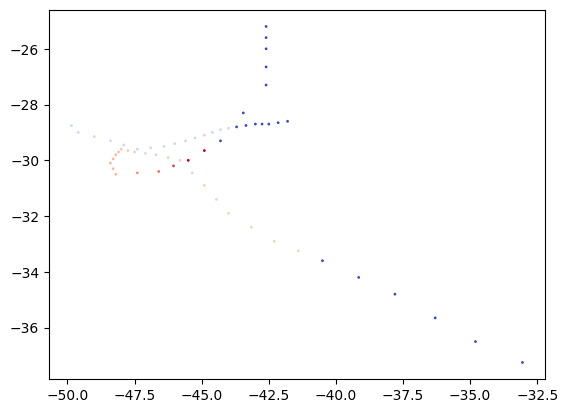

In [29]:
plt.scatter(contexts["train"].data[:,0,0], contexts["train"].data[:, 0, 1], c=contexts["train"].data[:,0,3], cmap=cmap1, s=1)

In [30]:
tcd_shifted = periodic_shift_TensorContextDataset(
    contexts["train"], basin=basin, verbose=True
)

SA 0


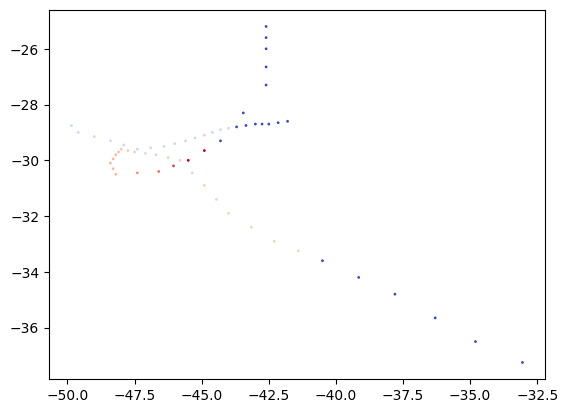

In [31]:
plt.scatter(tcd_shifted.data[:,0,0], tcd_shifted.data[:, 0, 1], c=tcd_shifted.data[:,0,3], cmap=cmap1, s=1)